INFO:root:X shape: (1503, 5), y shape: (1503,)
INFO:__main__:Best hyperparameters: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None, 'C': 0.615848211066026}
INFO:__main__:Mean accuracy: 0.5618688455897759
INFO:__main__:Scores: [0.52509653 0.54054054 0.55984556 0.56370656 0.62015504]
INFO:__main__:Classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        13
           5       0.67      0.76      0.71       120
           6       0.52      0.65      0.58       114
           7       0.60      0.17      0.27        52
           8       0.00      1.00      0.00         0

    accuracy                           0.58       301
   macro avg       0.30      0.43      0.26       301
weighted avg       0.57      0.58      0.55       301

INFO:__main__:Confusion matrix:
[[ 0  1  1  0  0  0]
 [ 1  0  9  3  0  0]
 [ 2  0 91 27  0  0]
 [ 0  0 34 74  6 

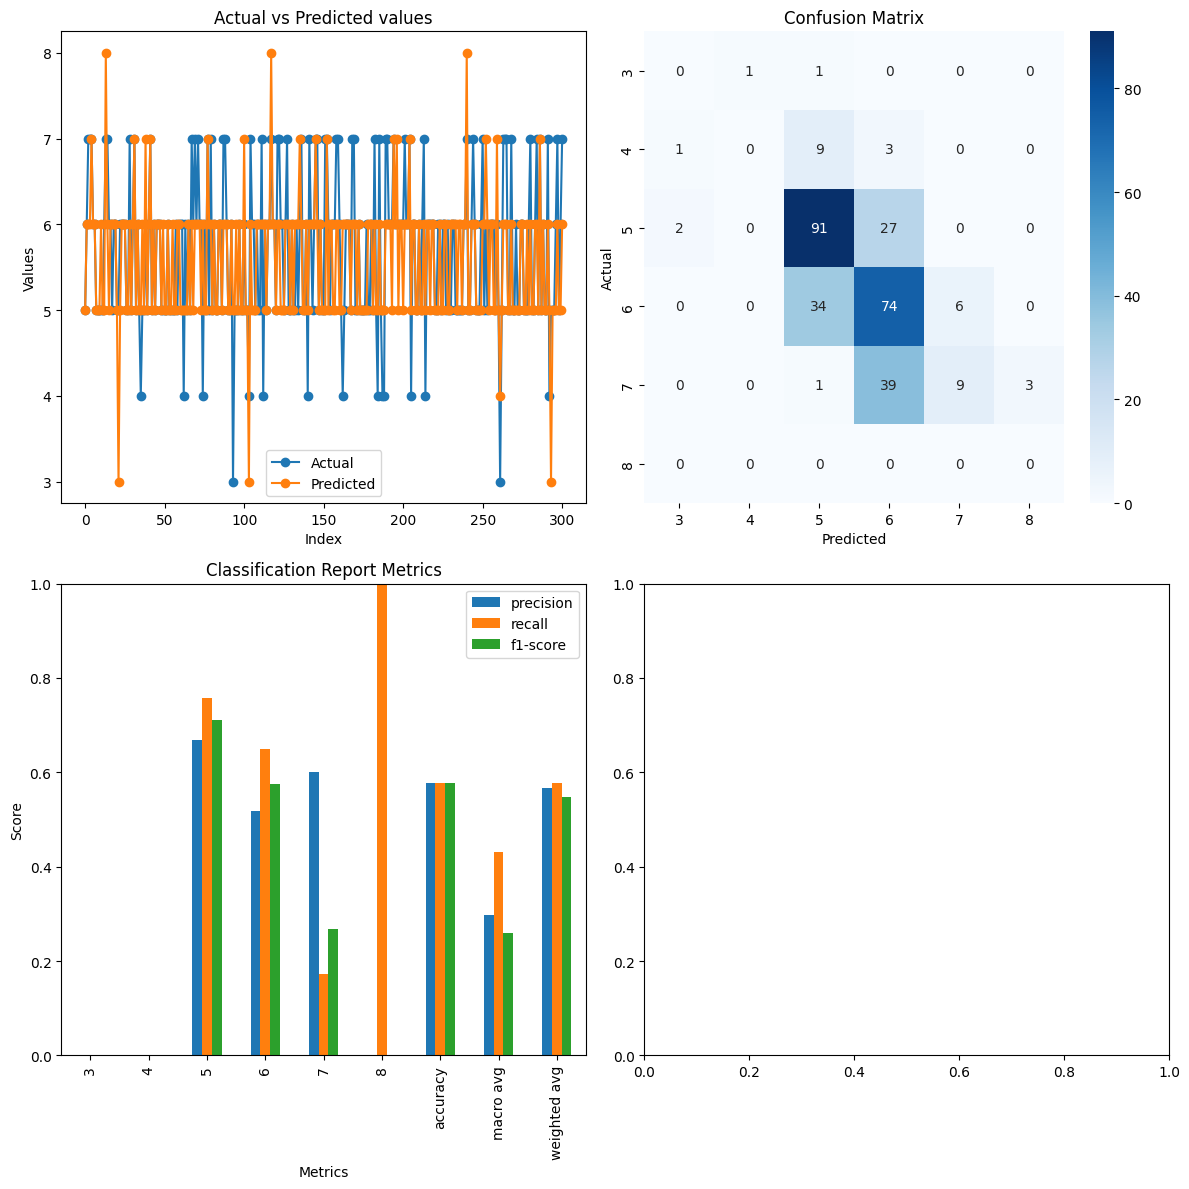

In [8]:
import pandas as pd
import numpy as np
import logging
from typing import Tuple, Dict, Any
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def initialize_data() -> Tuple[pd.DataFrame, pd.Series]:
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv').values.ravel()
    X = StandardScaler().fit_transform(X)
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")
    return X, y

def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(0.10 * max_count), count) for class_label, count in zip(unique, counts)}

def initialize_and_split_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    strategy = sampling_strategy(y_train)
    oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test

def evaluate_model(X_train, y_train, model, cv_splits):
    scores = cross_val_score(model, X_train, y_train, cv=cv_splits)
    return scores.mean(), scores

def optimize_hyperparameters(X_train, y_train, model, param_grid, n_iter=50, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    search = RandomizedSearchCV(model, param_grid, n_iter=n_iter, cv=cv, scoring='accuracy', random_state=42)
    search.fit(X_train, y_train)
    return search.best_params_

def cross_validate_with_optimized_params(X_train, y_train, model, best_params, cv_splits=5):
    model.set_params(**best_params)
    mean_accuracy, scores = evaluate_model(X_train, y_train, model, cv_splits)
    return mean_accuracy, scores

def generate_report(y_true, y_pred) -> Dict[str, Any]:
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    logger.info(f"Classification report:\n{classification_report(y_true, y_pred, zero_division=1)}")
    logger.info(f"Confusion matrix:\n{confusion_matrix(y_true, y_pred)}")
    return report

def display_plots(y_test, y_pred, report, class_labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=axs[0, 0], marker='o')
    axs[0, 0].set_title('Actual vs Predicted values')
    axs[0, 0].set_xlabel('Index')
    axs[0, 0].set_ylabel('Values')

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axs[0, 1], xticklabels=class_labels, yticklabels=class_labels)
    axs[0, 1].set_title('Confusion Matrix')
    axs[0, 1].set_xlabel('Predicted')
    axs[0, 1].set_ylabel('Actual')

    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=axs[1, 0])
    axs[1, 0].set_title('Classification Report Metrics')
    axs[1, 0].set_xlabel('Metrics')
    axs[1, 0].set_ylabel('Score')
    axs[1, 0].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def logistic_regression_main():
    try:
        X_train, X_test, y_train, y_test = initialize_and_split_data()
        model = LogisticRegression(max_iter=5000, random_state=42)

        param_grid = {
            'C': np.logspace(-4, 4, 20),
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs', 'newton-cg'],
            'class_weight': [None, 'balanced'],
            'tol': [1e-4, 1e-3, 1e-2, 1e-1]
        }

        best_params = optimize_hyperparameters(X_train, y_train, model, param_grid)
        logger.info(f"Best hyperparameters: {best_params}")

        mean_accuracy, scores = cross_validate_with_optimized_params(X_train, y_train, model, best_params)
        logger.info(f"Mean accuracy: {mean_accuracy}")
        logger.info(f"Scores: {scores}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = generate_report(y_test, y_pred)

        class_labels = np.unique(y_train)
        display_plots(y_test, y_pred, report, class_labels)

    except Exception as e:
        logger.error(f"An error occurred: {e}")
        raise

if __name__ == "__main__":
    logistic_regression_main()